In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

# Set AUTO for automatic tuning of data loading
AUTO = tf.data.experimental.AUTOTUNE

# Set AUTO for automatic tuning of data loading
import warnings
warnings.filterwarnings('ignore')


In [22]:
import os

# Set the folder path
folder1_path = "/content/train_cancer/malignant"
folder2_path = "/content/train_cancer/benign"


# List the contents of the folder
os.listdir(folder1_path)
os.listdir(folder2_path)


['17.jpg',
 '25.jpg',
 '33.jpg',
 '30.jpg',
 '42.jpg',
 '29.jpg',
 '6.jpg',
 '12.jpg',
 '22.jpg',
 '27.jpg',
 '14.jpg',
 '7.jpg',
 '35.jpg',
 '39.jpg',
 '4.jpg',
 '41.jpg',
 '34.jpg',
 '23.jpg',
 '36.jpg',
 '24.jpg',
 '38.jpg',
 '3.jpg',
 '32.jpg',
 '28.jpg',
 '40.jpg',
 '21.jpg',
 '20.jpg',
 '13.jpg',
 '19.jpg',
 '26.jpg']

In [23]:
# Get the image paths from each folder using glob
images1 = glob(folder1_path + '/*.jpg')
images2 = glob(folder2_path + '/*.jpg')

# Combine the two lists of images
images = images1 + images2

len(images1), len(images2), len(images)

(240, 30, 270)

In [24]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
# check if images is empty to avoid error on the next line
if images:
  df = pd.DataFrame({'filepath': images})
  df['label'] = df['filepath'].str.split('/', expand=True).iloc[:, -2]
  display(df.head())
else:
  print("No images were found in specified folder.")

,filepath,label
0,/content/drive/My Drive/train_cancer/malignant...,malignant
1,/content/drive/My Drive/train_cancer/malignant...,malignant
2,/content/drive/My Drive/train_cancer/malignant...,malignant
3,/content/drive/My Drive/train_cancer/malignant...,malignant
4,/content/drive/My Drive/train_cancer/malignant...,malignant


In [25]:
# Create a binary label column
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,/content/drive/My Drive/train_cancer/malignant...,malignant,1
1,/content/drive/My Drive/train_cancer/malignant...,malignant,1
2,/content/drive/My Drive/train_cancer/malignant...,malignant,1
3,/content/drive/My Drive/train_cancer/malignant...,malignant,1
4,/content/drive/My Drive/train_cancer/malignant...,malignant,1


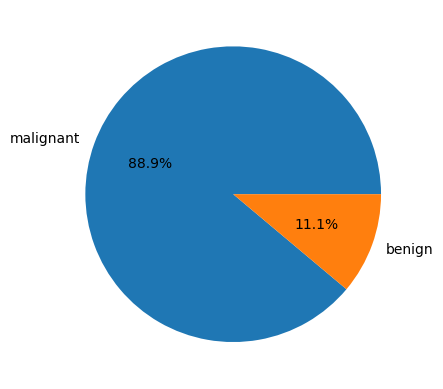

In [26]:
# Plot the distribution of malignant and benign
x = df['label_bin'].value_counts()
plt.pie(x.values,
        labels=['malignant', 'benign'],
        autopct='%1.1f%%')
plt.show()


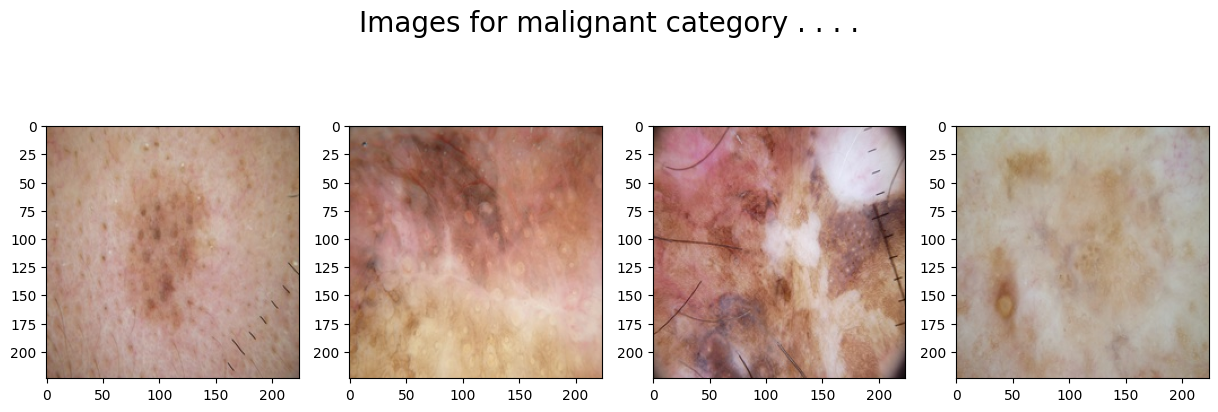

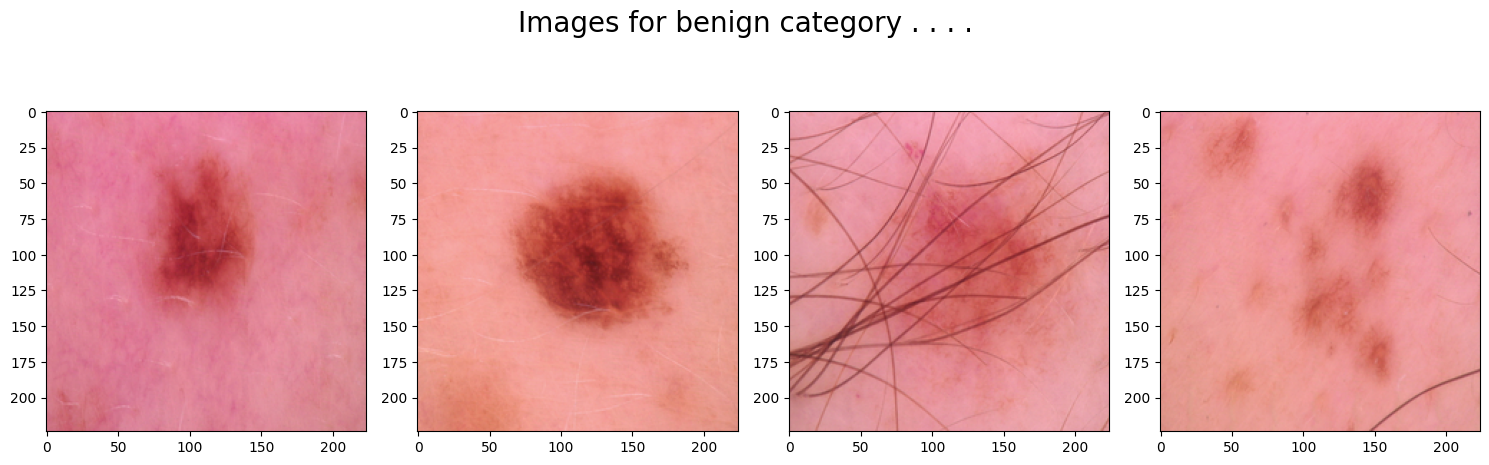

In [27]:
# Display sample images from each category
for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()


In [28]:
# Split data into training and validation sets
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape


((229,), (41,))

In [29]:
# Function to decode and preprocess images
def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224]) # Resize images to a fixed size
    img = tf.cast(img, tf.float32) / 255.0

    # Compare label with integer 0 or 1 instead of string
    if label is not None: #check if label is not None before accessing it.
        label = 0 if label == 0 else 1

    return img, label


In [36]:
# Create TensorFlow Datasets for training and validation
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


In [37]:
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB7

# Load the pre-trained model
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

# Freeze the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Define the input layer
inputs = layers.Input(shape=(224, 224, 3))

# Pass the inputs through the pre-trained model
x = pre_trained_model(inputs)

# Add your custom layers on top of the pre-trained model
x = layers.Flatten()(x)  # Flatten the output of the pre-trained model
x = layers.Dense(256, activation='relu')(x)# Add a dense layer with 256 units and ReLU activation
x = layers.BatchNormalization()(x) # Add batch normalization for faster and more stable training
x = layers.Dense(256, activation='relu')(x)# Add another dense layer with 256 units and ReLU activation
x = layers.Dropout(0.3)(x)# Add dropout to prevent overfitting
x = layers.BatchNormalization()(x)# Add batch normalization for faster and more stable training
outputs = layers.Dense(1, activation='sigmoid')(x)# Add the output layer with 1 unit and sigmoid activation for binary classification

# Create the final model
model = Model(inputs, outputs)

In [38]:
# Model Compilation
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['AUC']
)


In [40]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    verbose=1)


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 160s 20s/step - AUC: 0.5363 - loss: 0.7197 - val_AUC: 0.5000 - val_loss: 5.4262
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 218s 23s/step - AUC: 0.5053 - loss: 0.6694 - val_AUC: 0.8056 - val_loss: 0.7782
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 203s 23s/step - AUC: 0.4373 - loss: 0.6454 - val_AUC: 0.5000 - val_loss: 0.6016
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 200s 22s/step - AUC: 0.4725 - loss: 0.5828 - val_AUC: 0.5000 - val_loss: 0.6245
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 201s 22s/step - AUC: 0.5220 - loss: 0.5486 - val_AUC: 0.5000 - val_loss: 0.6199


In [41]:
# Model Evaluation
# Create a DataFrame from the training history
hist_df = pd.DataFrame(history.history)
hist_df.head()


,AUC,loss,val_AUC,val_loss
0,0.534412,0.709021,0.500000,5.426222
1,0.544510,0.650428,0.805556,0.778195
2,0.499902,0.621889,0.500000,0.601598
3,0.472255,0.578575,0.500000,0.624474
4,0.500490,0.545765,0.500000,0.619903


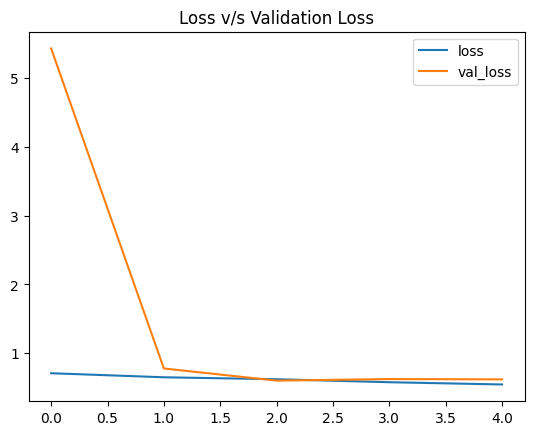

In [42]:
# Plot the training and validation loss
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()


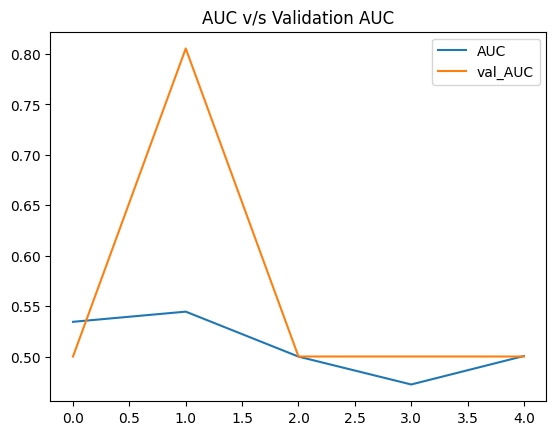

In [43]:
# Plot the training and validation AUC
hist_df['AUC'].plot() # Access using 'AUC' instead of 'auc'
hist_df['val_AUC'].plot() # Access using 'val_AUC' instead of 'val_auc'
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()
